# Explore the Traits of Single Cells in their Lineage Trees:

Our single cell tracking algorithm `bTrack` allows us to extract invaluable information about the progression of single cell life at large scale. Let's explore some of the features which we can automatically have a detailed look at:

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from Tree_DataIO import Extract_Tree_Branches_from_HDF
from Tree_Plotter import Lineage_Tree, LineageTreePlotter_Figure


In an example movie, which has been already segmented, classified and tracked, we'll explore one of the deep lineage trees capturing multiple generations: **tree #56** (note that assignment of the tree ID & the ID of the tree founder cell is identical):

In [2]:
bt_file = "../example_segment_classif_tracked_movie.hdf5"


In [3]:
tree_IDs = [56]
print (f"Lineage Trees : {len(tree_IDs)}")


Lineage Trees : 1


### Visualise the automatically reconstructed *DeepTree*:

You don't have to manually draw the branches or create the associations - it's all done for you! :-)

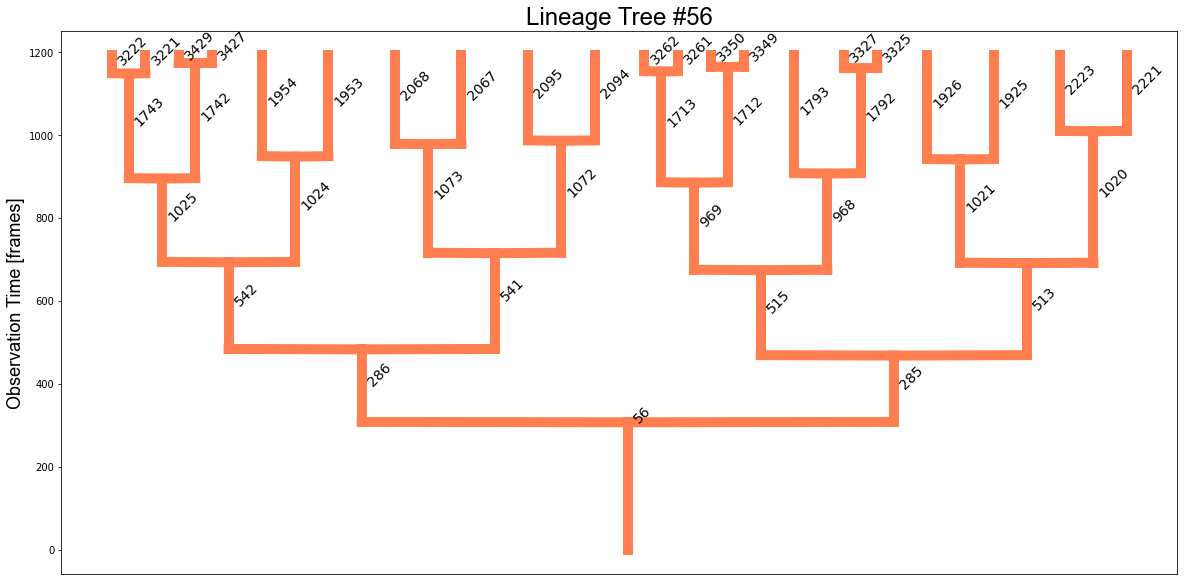

In [4]:
for enum, tree_ID in enumerate(tree_IDs):
    
    fig = plt.subplots(figsize=(20, 10))
    
    bt = Extract_Tree_Branches_from_HDF(tree_ID, hdf5_file=bt_file)
    tree_bt = Lineage_Tree(hdf5_file=bt_file, tree_root_ID=tree_ID)
    tree = tree_bt.create_tree()
    LineageTreePlotter_Figure(axis_index=0, order=0).plot(tree=tree, color="coral", linewidth=10.0, markersize=0, alpha=1.0, labels=True)
    
    plt.xticks([])
    plt.title(f"Lineage Tree #{tree_ID}", fontname="Arial", fontsize=24)
    plt.ylabel("Observation Time [frames]", fontname="Arial", fontsize=18)

    plt.show()
    
    

### Extract information about single particular cell: 

Here, I've chosen a cell with ID: #285 from lineaege tree #56 as seen above. It has a generational depth of *1* (with reference to the tree founder cell #56, which has a conventional depth of *0*). The cell appears to exists for roughly 200 frames - from frame #300 to frame #500, which can be directly read from the y-axis on the figure. 

Let's check how long the cell lives for & remember some of its per-frame data & its coordinates at every field of view (1,600 x 1,200 px)

*Note:* 100 frames = 6.66 hours. 

In [5]:
candidate_cell = 285


In [6]:
def displacement(x1, x2, y1, y2):
    return np.sqrt( (x1 - x2) ** 2 + (y1 - y2) ** 2 )


In [7]:
with h5py.File(bt_file, "r") as f:
    
    for enum, cell in enumerate(f["tracks"]["obj_type_1"]["LBEPR"]):
        
        if cell[0] == candidate_cell:
            
            cell_cycle_duration = round((cell[2]-cell[1]) * 4 / 60, 2)
            print (f"Cell ID: {cell[0]}\nCell cycle duration: {cell[2]-cell[1]+1} frames which corresponds to {cell_cycle_duration} hours")
            
            nuc, den, sig, mig, cumul = [], [], [], [], []
            cell_map = f["tracks"]["obj_type_1"]["map"][enum]
            
            for e, frm in enumerate(range(cell_map[0], cell_map[1])):
                trk_now = f["tracks"]["obj_type_1"]["tracks"][frm]
                trk_fut = f["tracks"]["obj_type_1"]["tracks"][frm+1]
                
                nuc.append(f["objects"]["obj_type_1"]["nucleus_size"][trk_now])
                den.append(f["objects"]["obj_type_1"]["local_density"][trk_now])
                sig.append(f["objects"]["obj_type_1"]["fluo_signal_sum"][trk_now])

                if e == 0:
                    origin_x, origin_y = f["objects"]["obj_type_1"]["coords"][trk_now][1], f["objects"]["obj_type_1"]["coords"][trk_now][2]
                    print (f"Cell coordinates at origin: x = {np.round(origin_x, decimals=2)}; y = {np.round(origin_y, decimals=2)}")
                    mig.append(0)
                
                if e + 1 < len(list(range(cell_map[0], cell_map[1]))):
                    current_x, current_y = f["objects"]["obj_type_1"]["coords"][trk_now][1], f["objects"]["obj_type_1"]["coords"][trk_now][2]
                    future_x, future_y = f["objects"]["obj_type_1"]["coords"][trk_fut][1], f["objects"]["obj_type_1"]["coords"][trk_fut][2]
                    displacement_between_frames = displacement(x1=current_x, y1=current_y, x2=future_x, y2=future_y)
                    mig.append(displacement_between_frames)
                
                    if e < 0:
                        continue
                    elif e == 0:
                        cumul.append(0)
                    else:
                        #cumulative_disp_from_origin = displacement(x1=origin_x, y1=origin_y, x2=future_x, y2=future_y)
                        cumul.append(cumul[-1] + displacement_between_frames)
                        if e == len(list(range(cell_map[0], cell_map[1]))) - 2:
                            cumul.append(0)
            

Cell ID: 285
Cell cycle duration: 161 frames which corresponds to 10.67 hours
Cell coordinates at origin: x = 645.8200073242188; y = 471.8399963378906


### Plot the mini-graphs to visualise the single cell traits:

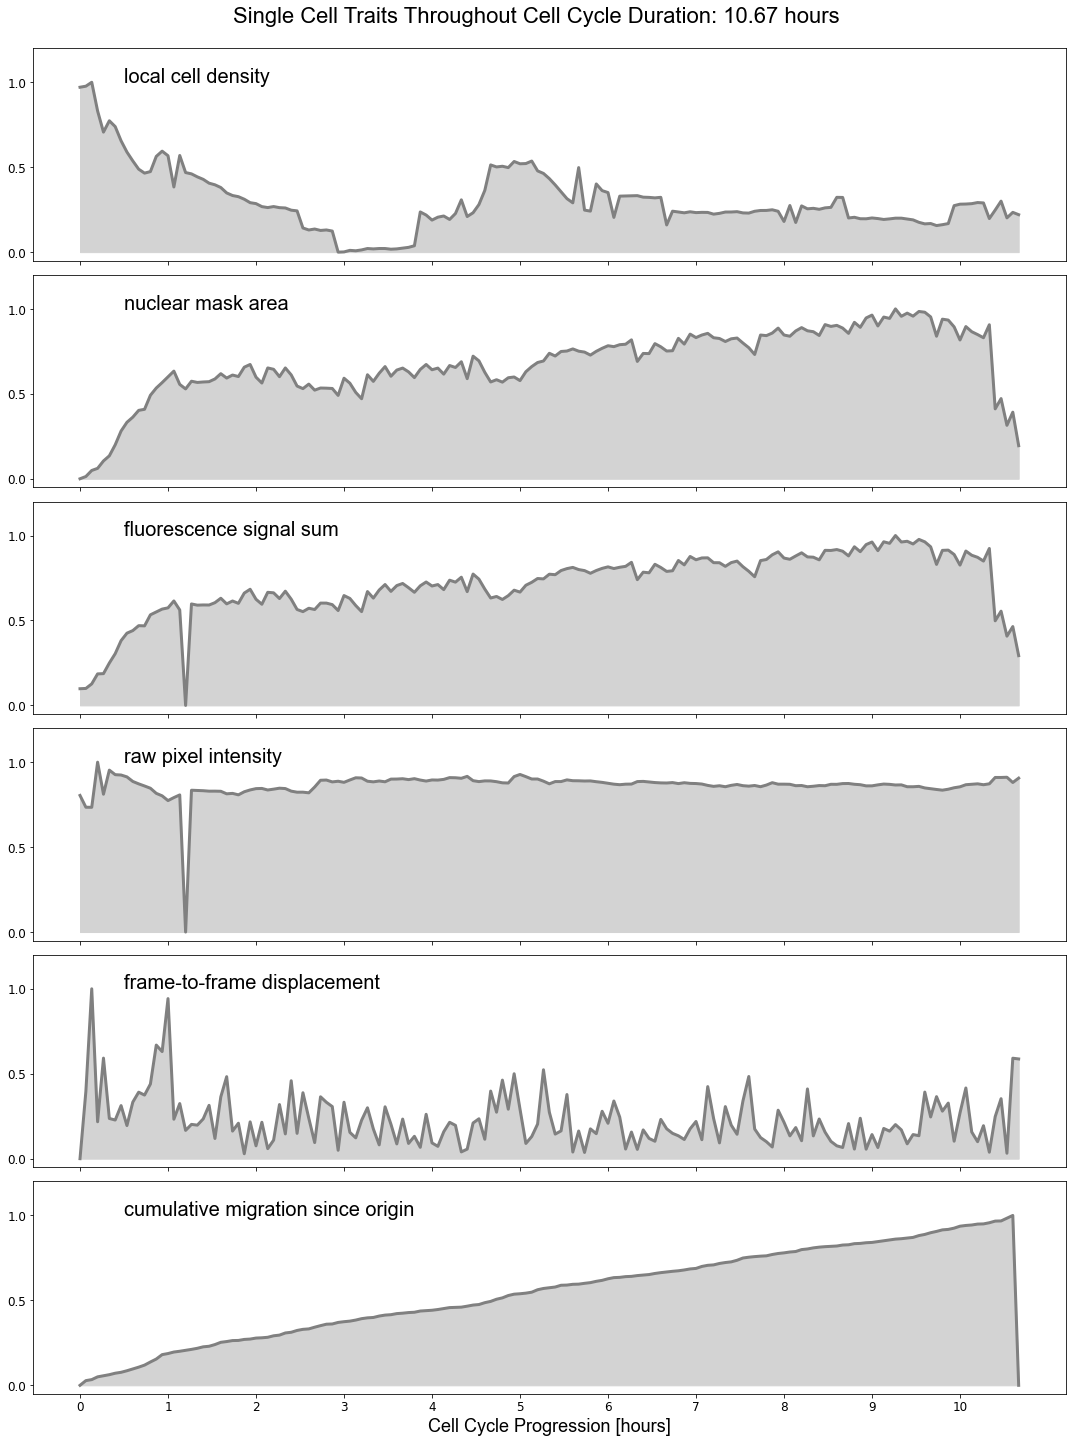

In [8]:
fig, axs = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(15, 20))
fig.suptitle(x=0.5, y=1.0, t=f"Single Cell Traits Throughout Cell Cycle Duration: {cell_cycle_duration} hours", fontname="Arial", fontsize=22)

for enumer, (data, name) in enumerate(zip([den, nuc, sig, [s/n for n, s in zip(nuc, sig)], mig, cumul], 
    ["local cell density", "nuclear mask area", "fluorescence signal sum", "raw pixel intensity", "frame-to-frame displacement", "cumulative migration since origin"])):
    
    axs[enumer].plot([item * 4 / 60 for item in range(len(data))], [(item - np.min(data)) / (np.max(data) - np.min(data)) for item in data], color="grey", linewidth=3.0)
    axs[enumer].fill_between(x=[item * 4 / 60 for item in range(len(data))], y1=[(item - np.min(data)) / (np.max(data) - np.min(data)) for item in data], y2=0, color="lightgrey")
    
    axs[enumer].set_yticks([item / 100 for item in range(0, 100 + 1, 50)])
    axs[enumer].set_xticks([item * 4 / 60 for item in range(0, len(data) + 1, 15)])
    axs[enumer].text(x=0.5, y=1.0, s=name, fontname="Arial", fontsize=20)
    axs[enumer].set_ylim(-0.05, 1.2)
    axs[enumer].tick_params(labelsize=12)

plt.xlabel("Cell Cycle Progression [hours]", fontname="Arial", fontsize=18)    
plt.tight_layout()
plt.show()


### Visualise Cell Migration Pattern as a Spider Web Graph:

In [9]:
coords = []

with h5py.File(bt_file, 'r') as f:
    for e, cell in enumerate(f["tracks"]["obj_type_1"]["LBEPR"]):
        if cell[0] == candidate_cell:
            cell_map = f["tracks"]["obj_type_1"]["map"][e]
            for trk in f["tracks"]["obj_type_1"]["tracks"][cell_map[0]:cell_map[1]]:
                coo = f["objects"]["obj_type_1"]["coords"][trk]
                coords.append((coo[1], coo[2]))


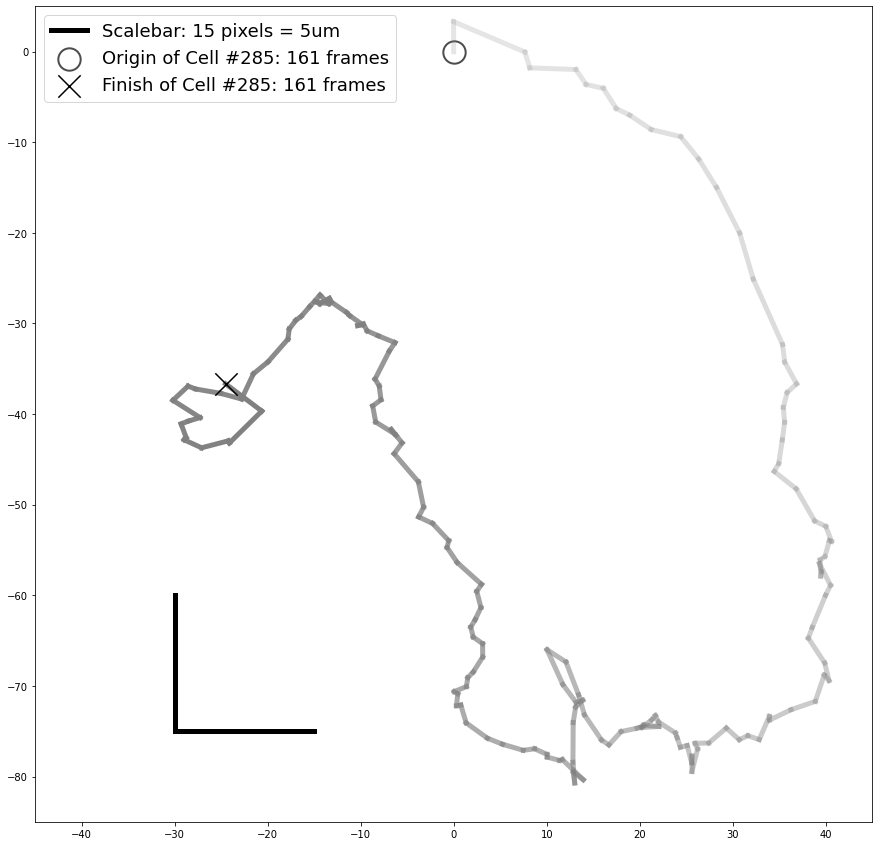

In [10]:
fig = plt.figure(figsize=(15, 15))

coords_cell = [(item[0] - coords[0][0], item[1] - coords[0][1]) for item in coords]
alpha = np.linspace(0.2, 1, len(coords_cell))
x, y = np.array(coords_cell).T.tolist()

# Plot the origin marker:
plt.scatter(x[0], y[0], marker='o', s=500, color="white", edgecolors="black", linewidths=2, alpha=0.7, label=f"Origin of Cell #{candidate_cell}: {len(x)} frames")
    
# Plot the gradually opaque lines:
for enum, a in enumerate(alpha[:-1]):
    plt.plot([x[enum], x[enum+1]], [y[enum], y[enum+1]], '-', linewidth=5, color="grey", alpha=a)
    
# Plot the finish of track:
plt.scatter(x[-1], y[-1], marker='x', s=500, color="black", alpha=1.0, label=f"Finish of Cell #{candidate_cell}: {len(x)} frames", zorder=20)
    
# Insert scalebars:
plt.plot([-30, -15], [-75, -75], '-', linewidth=5.0, color="black", label="Scalebar: 15 pixels = 5um")
plt.plot([-30, -30], [-75, -60], '-', linewidth=5.0, color="black")
    
plt.xlim(-45, 45)
plt.ylim(-85, 5)
plt.legend(fontsize=18)
plt.show()


## Visualise the glimpses:

### Zoom in to a single cell:

In [11]:
limit = 50


161it [00:15, 10.24it/s]


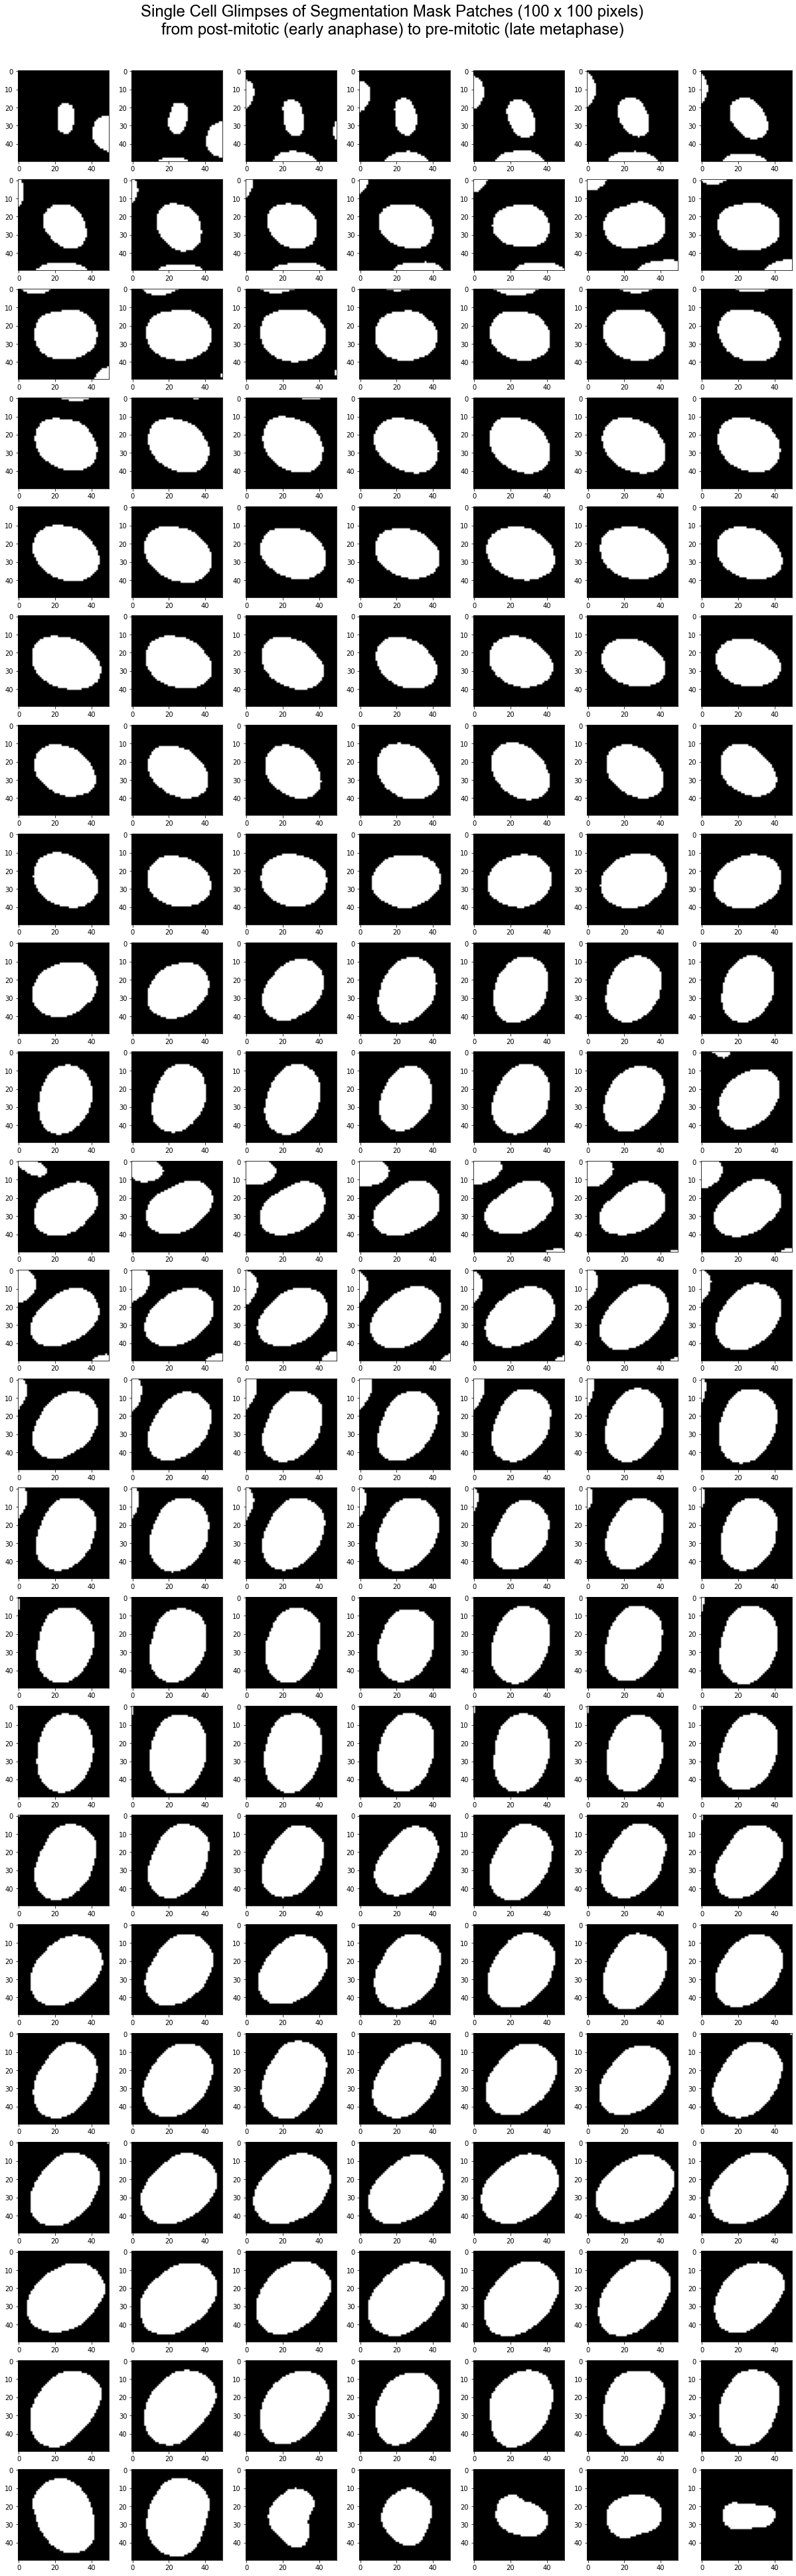

In [12]:
fig, axs = plt.subplots(figsize=(21, 69), nrows=23, ncols=7)
fig.suptitle(x=0.5, y=0.9, t=f"Single Cell Glimpses of Segmentation Mask Patches ({limit*2} x {limit*2} pixels)\nfrom post-mitotic (early anaphase) to pre-mitotic (late metaphase)", fontname="Arial", fontsize=24)

with h5py.File(bt_file, 'r') as f:
    for cell in f["tracks"]["obj_type_1"]["LBEPR"]:
        if cell[0] == candidate_cell:
            
            for e, (coo, frm) in tqdm(enumerate(zip(coords, range(cell[1], cell[2] + 1)))):
                
                image = f["segmentation"]["images"][frm]
                crop = np.array([item[int(coo[1]-limit/2):int(coo[1]+limit/2)] 
                                for item in 
                                image[int(coo[0]-limit/2):int(coo[0]+limit/2)]])
    
                axs[e//7][e%7].imshow(crop, cmap="binary_r")
        
plt.show()


### Zoom out to see cell's microenvironment:

In [13]:
limit = 100

161it [00:16,  9.95it/s]


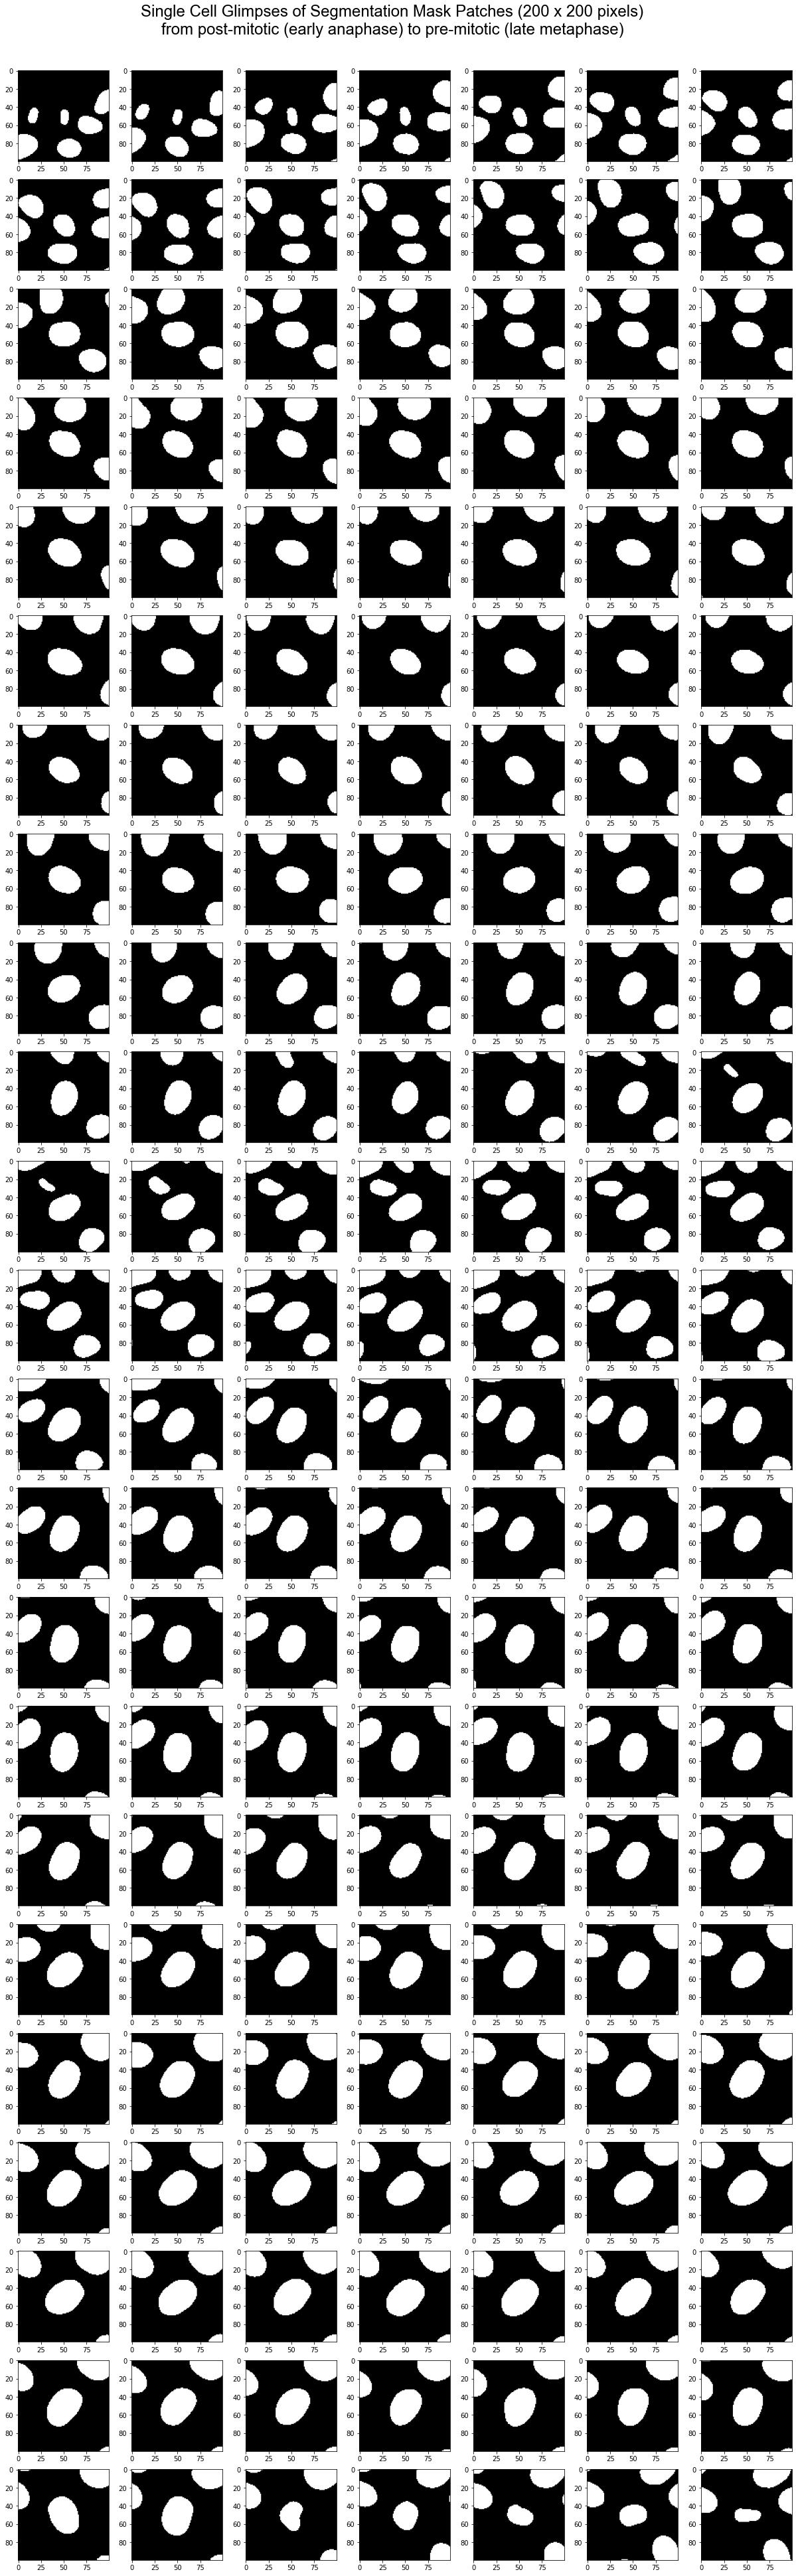

In [14]:
fig, axs = plt.subplots(figsize=(21, 69), nrows=23, ncols=7)
fig.suptitle(x=0.5, y=0.9, t=f"Single Cell Glimpses of Segmentation Mask Patches ({limit*2} x {limit*2} pixels)\nfrom post-mitotic (early anaphase) to pre-mitotic (late metaphase)", fontname="Arial", fontsize=24)

with h5py.File(bt_file, 'r') as f:
    for cell in f["tracks"]["obj_type_1"]["LBEPR"]:
        if cell[0] == candidate_cell:
            
            for e, (coo, frm) in tqdm(enumerate(zip(coords, range(cell[1], cell[2] + 1)))):
                
                image = f["segmentation"]["images"][frm]
                crop = np.array([item[int(coo[1]-limit/2):int(coo[1]+limit/2)] 
                                for item in 
                                image[int(coo[0]-limit/2):int(coo[0]+limit/2)]])
    
                axs[e//7][e%7].imshow(crop, cmap="binary_r")
                
plt.show()


### Done!